In [ ]:
## command to run to infer 12M queries

# python main_inference_multimodal.py \
#         --model=LLM_Inference_Multimodal \
#         --model.llm_type="clm" \
#         --model.output_scores=true \
#         --model.ckpt_path="models/multitask_multimodal_multilingual/version_9/epoch=1-step=2600.ckpt" \
#         --model.config_path="models/multitask_multimodal_multilingual/version_9/config.yaml" \
#         --model.task="clm_singlemodal_wishquery2tax" \
#         --model.allowed_gen_sequences="datasets/taxonomy/wish_v1.2.1_newtax_allpaths.txt" \
#         --model.num_beams=3 \
#         --model.num_return_sequences=3 \
#         --model.length_penalty=0 \
#         --model.do_sample=false \
#         --model.max_new_tokens=50 \
#         --model.output_dir="models/multitask_multimodal_multilingual/version_9" \
#         --model.write_interval="batch" \
#         --data=JSONListData \
#         --data.llm_type="clm" \
#         --data.data_source_yaml_path="datasets/multimodal_multitask/wish_3yr_queries_12M_headtail_sample.yaml" \
#         --data.input_dict="{'template': '{query}', 'task_prefix': 'Generate taxonomy for query: '}" \
#         --data.output_dict="{'template': '{query}'}" \
#         --data.data_source_type="dvc" \
#         --data.model_name="google/mt5-base" \
#         --data.batch_size=50 \
#         --data.max_length=50 \
#         --data.num_workers=0 \
#         --data.max_length_out=50 \
#         --data.predict_on_test=true \
#         --trainer.logger=false \
#         --trainer.enable_checkpointing=false \
#         --trainer.accelerator gpu \
#         --trainer.strategy ddp

In [1]:
import pandas as pd
import dvc.api

In [2]:
df = pd.read_json('../../models/multitask_multimodal_multilingual/version_9/clm-epoch=1-step=2600--wish_3yr_queries_12M_headtail_sample--test.json', 
    lines=True)

In [5]:
df_query = pd.read_json(dvc.api.get_url(
    'datasets/data/query/wish_queries_with_timestamp_3yr_all_sample_12M_headtail.json',
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
), lines=True)

In [14]:
df_query

,query,min_timestamp,max_timestamp,min_dt,max_dt,cnt,gmv,sample_method,label_ordering
0,digital measurement tape,1577816493,1667154019,2020-01-01,2022-10-31,298,0.000000,head,0
1,máquina singer,1578798301,1669681981,2020-01-12,2022-11-29,629,23.688904,head,1
2,mens summer tee,1588359626,1641584512,2020-05-02,2022-01-08,25,0.000000,uniform,2
3,5d81ea40f8ebae3f8645fb92,1591962614,1594600431,2020-06-13,2020-07-13,140,0.000000,head,3
4,strass emblemen,1581023561,1581023561,2020-02-07,2020-02-07,1,0.000000,uniform,4
...,...,...,...,...,...,...,...,...,...
11939641,steine kleben,1578396273,1666631606,2020-01-08,2022-10-25,163,0.000000,head,11939641
11939642,wigs human hair for black women,1577902600,1669783688,2020-01-02,2022-11-30,34965,2826.243652,head,11939642
11939643,robe danse tangongo,1625602413,1625602413,2021-07-07,2021-07-07,1,0.000000,uniform,11939643
11939644,センターキャップ 54mm,1584866218,1669381685,2020-03-23,2022-11-26,1202,59.559296,head,11939644


In [15]:
df_merge = df.rename(columns={'batch_indices': 'label_ordering'}).merge(df_query, on='label_ordering', how='inner')

<AxesSubplot: ylabel='Frequency'>

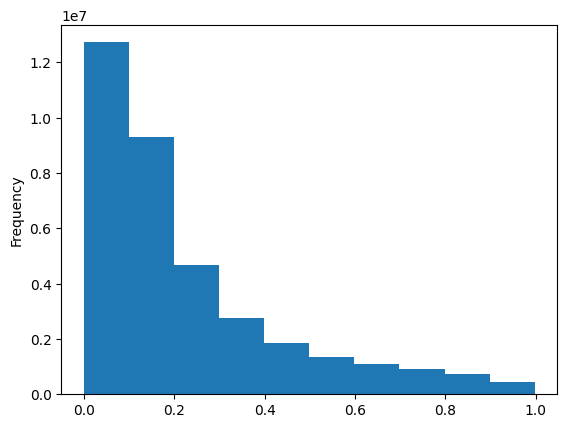

In [17]:
df_merge.prob.plot.hist()

In [25]:
df_merge = df_merge[df_merge.prob > .05]

In [30]:
df_tax = pd.read_json(dvc.api.get_url(
    'datasets/data/taxonomy/wish_newtax.json',
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
), lines=True)

In [32]:
paths = set(df_tax[df_tax.category_path.apply(len) > 0].category_path.apply(lambda x: x.lower().strip()))

In [33]:
df_merge.prediction_decoded.apply(lambda x: x in paths).all()

True

In [36]:
queries = sorted(list(set(df_merge['query'])))

In [35]:
from sklearn.model_selection import train_test_split

In [38]:
train_queries, val_queries = train_test_split(queries, test_size=20000)

In [40]:
len(train_queries), len(val_queries)

(11603222, 20000)

In [41]:
assert len(set(train_queries).intersection(val_queries)) == 0

In [44]:
df_out = df_merge[['query', 'prediction_decoded']].rename(columns={'prediction_decoded': 'category'})

In [46]:
df_out.head(5).to_dict('records')

[{'query': 'porte clef voiture jeep',
  'category': 'automobiles & motorcycles > interior accessories > key case for car'},
 {'query': 'porte clef voiture jeep',
  'category': 'automobiles & motorcycles > interior accessories > key rings'},
 {'query': 'camera gopro hero 7',
  'category': 'consumer electronics > live equipment > action cameras'},
 {'query': 'camera gopro hero 7',
  'category': 'consumer electronics > camera & photo > tripod & accessories > tripods'},
 {'query': 'camera gopro hero 7',
  'category': 'consumer electronics > camera & photo > camera & photo accessories > action video cameras accessories'}]

In [49]:
df_out_train = pd.DataFrame({'query': train_queries}).merge(df_out, on='query', how='inner')
df_out_val = pd.DataFrame({'query': val_queries}).merge(df_out, on='query', how='inner')

In [50]:
len(df_out_train), len(df_out_val), len(set(df_out_train['query']).intersection(df_out_val['query']))

(29871552, 51558, 0)

In [52]:
df_out_train.to_json('wish_queries_with_timestamp_3yr_all_sample_12M_headtail_qcv2_pseudolabel_train.json', orient='records', lines=True)
df_out_val.to_json('wish_queries_with_timestamp_3yr_all_sample_12M_headtail_qcv2_pseudolabel_val.json', orient='records', lines=True)